# Figure 7

Pairwise differences in neurophysiological differentiation among stimuli

In [1]:
from pathlib import Path

import pandas as pd
from IPython.display import Image

from analysis import CONTINUOUS_NATURAL
from metadata import STIMULUS_METADATA

In [2]:
OUTPUT_DIR = Path('figures')

## Set up R

In [3]:
%load_ext rpy2.ipython

In [4]:
%%R
library(tidyverse)
library(broom)
library(ggplot2)
library(lme4)
library(multcomp)
library(emmeans)

theme_set(theme_minimal())

R[write to console]: Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

R[write to console]: Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

R[write to console]: ✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘Matrix’


R[write to console]: The following object is masked from ‘package:tidyr’:

    expand


R[write to console]: Loading required package: mvtnorm

R[wri

## Load data

In [5]:
df = pd.read_parquet("results/main.parquet")

In [6]:
# Compare continuous natural stimuli
df = df.loc[
    df['stimulus'].isin(CONTINUOUS_NATURAL)
]

In [7]:
response = "log(normalized differentiation)"

## Fit model

In [8]:
formula = f"`{response}` ~ 1 + stimulus + (1 | session)"
reduced_formula = f"`{response}` ~ 1 + (1 | session)"
print(formula)
print(reduced_formula)

`log(normalized differentiation)` ~ 1 + stimulus + (1 | session)
`log(normalized differentiation)` ~ 1 + (1 | session)


In [9]:
%%R -i df -i formula -i reduced_formula

# Estimate models
model = lmer(formula, data=df, REML=FALSE)
reduced_model = lmer(reduced_formula, data=df, REML=FALSE)

# Compare models
model_comparison = anova(model, reduced_model)
print(model_comparison)

Data: df
Models:
reduced_model: `log(normalized differentiation)` ~ 1 + (1 | session)
model: `log(normalized differentiation)` ~ 1 + stimulus + (1 | session)
              Df    AIC    BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)    
reduced_model  3 2926.0 2943.1 -1460.0   2920.0                             
model          7 2901.8 2941.7 -1443.9   2887.8 32.115      4  1.812e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


### Post hoc tests of pairwise differences in estimated marginal means among stimuli

In [10]:
%%R -o pairwise_differences

# Estimate marginal means
posthoc = emmeans(model, list(pairwise ~ stimulus), adjust='tukey', alternative='two.sided')

means = posthoc$`emmeans of stimulus`
pairwise_differences = posthoc$`pairwise differences of stimulus`
pairwise_differences = tidy(pairwise_differences)

In [11]:
pairwise_differences

,level1,level2,estimate,std.error,df,z.ratio,p.value
1,conspecifics,crickets (prey),0.021125,0.030205,inf,0.699393,0.956678
2,conspecifics,man writing,0.061020,0.030205,inf,2.020217,0.256156
3,conspecifics,mousecam,-0.041568,0.030205,inf,-1.376211,0.642996
4,conspecifics,snake (predator),-0.097520,0.030205,inf,-3.228648,0.010909
5,crickets (prey),man writing,0.039895,0.030205,inf,1.320824,0.678213
6,crickets (prey),mousecam,-0.062693,0.030205,inf,-2.075604,0.230645
7,crickets (prey),snake (predator),-0.118645,0.030205,inf,-3.928041,0.000815
8,man writing,mousecam,-0.102588,0.030205,inf,-3.396428,0.006146
9,man writing,snake (predator),-0.158540,0.030205,inf,-5.248865,0.000002
10,mousecam,snake (predator),-0.055952,0.030205,inf,-1.852437,0.343408


### Plot

In [12]:
path = OUTPUT_DIR / "fig-7/pairwise_stimulus_estimated_marginal_mean_differences.png"
path.parent.mkdir(exist_ok=True)
path = str(path)

In [13]:
%%R -i path

p = (
    pwpp(means) 
    + scale_colour_grey(start=0, end=0) 
    + theme(text = element_text(family = 'Roboto'))
)

ggsave(
    path,
    p,
    width=7,
    height=3.5,
    dpi=300,
)

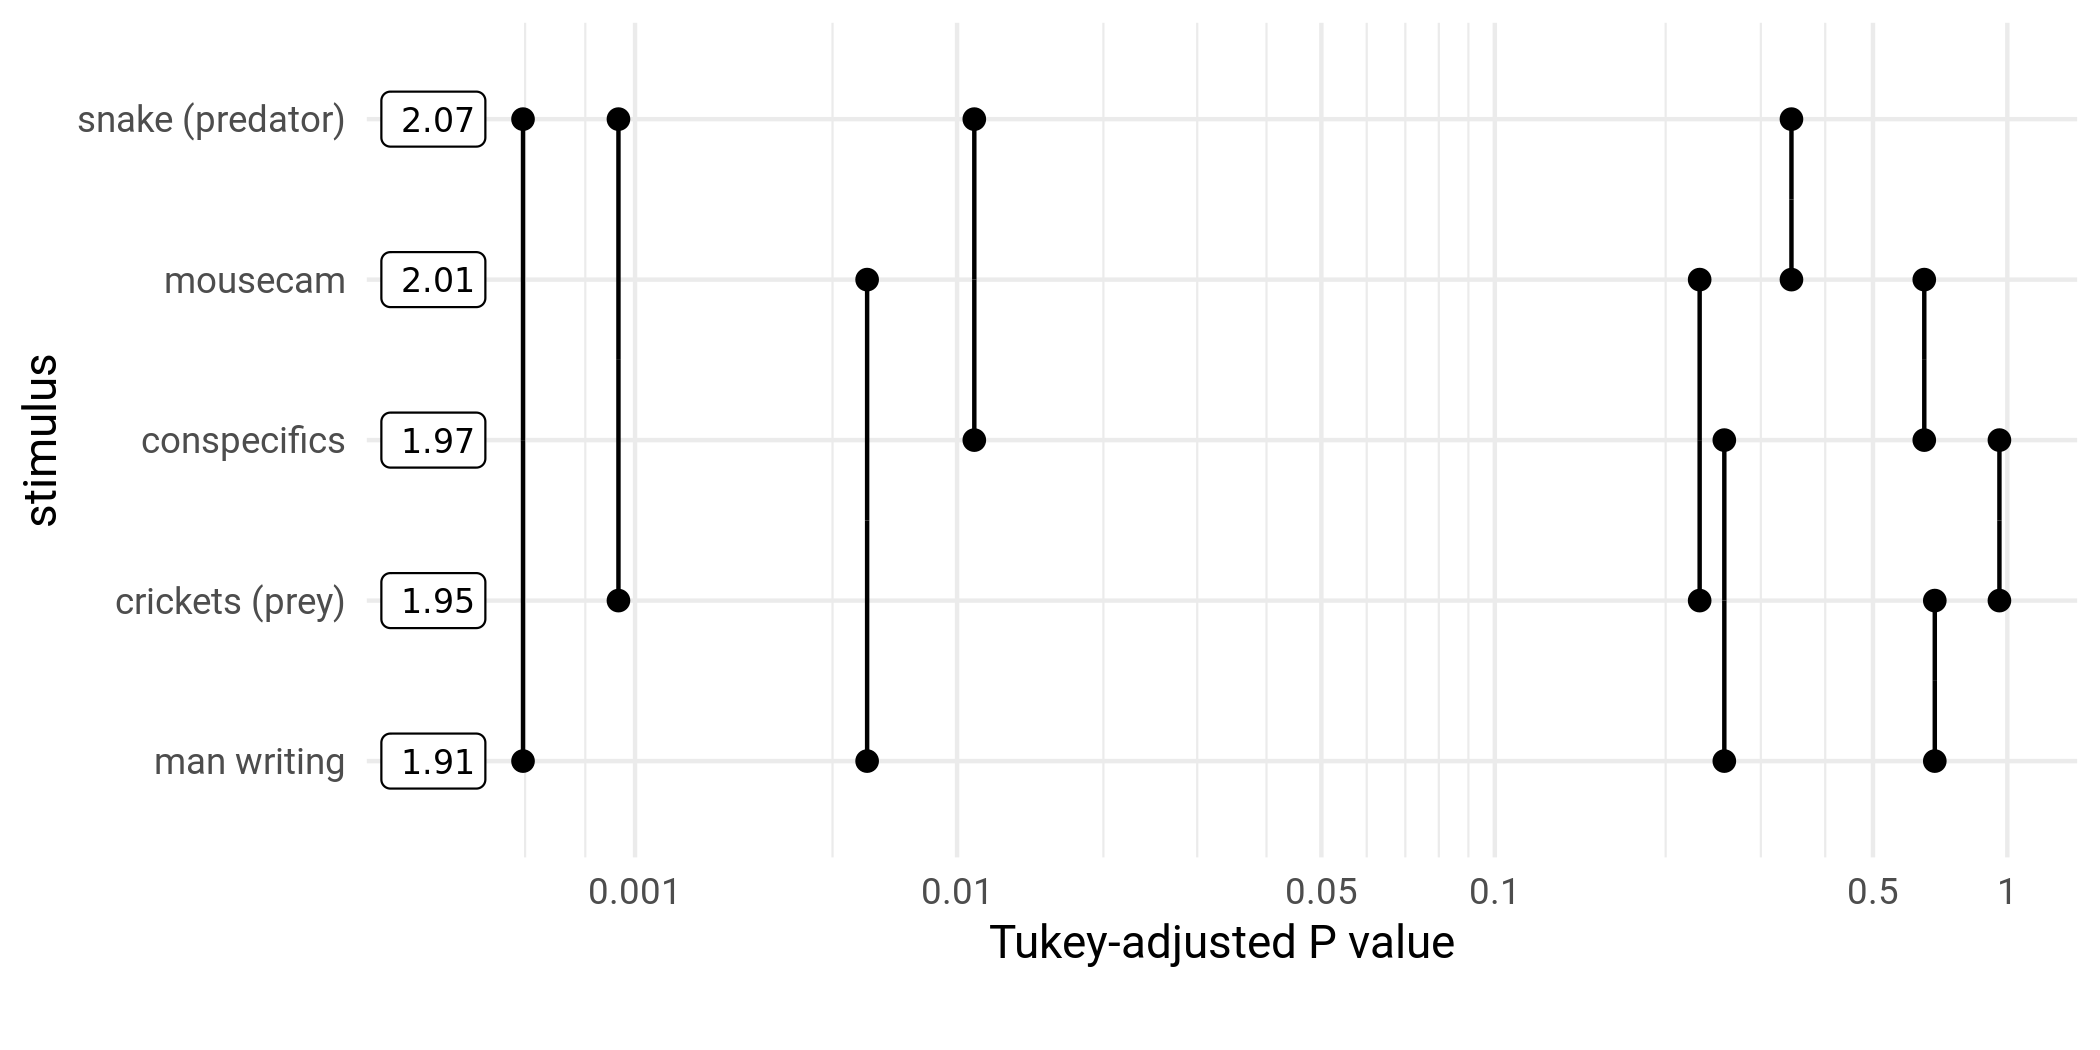

In [14]:
Image(filename=path)